# Trabalho 1 - Inteligência Artificial

## Imports necessários

In [89]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.utils.validation import check_X_y
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
from sklearn.base import BaseEstimator

## Base de dados

### Matrícula: 2015100346
Dessa forma, devido ao final da matrícula ser 6, a base de dados será composta pelos 10 descritores de Fourier e os 7 descritores de Hu.

In [90]:
# Leitura dos dados
df = pd.read_csv('https://raw.githubusercontent.com/VitorBonella/PL-Dataset/main/dataset.csv',sep=";") 

# Transformando a coluna id no índice da tabela
df.set_index('id', inplace=True)

# Lista de descritores
FOURIER = ['df01', 'df02', 'df03', 'df04','df05', 'df06', 'df07', 'df08', 'df09', 'df10']
HU = ['i1', 'i2', 'i3', 'i4','i5', 'i6', 'i7']
HARALICK = ['probmax', 'energia', 'entropia', 'contraste','homogeneidade', 'correlacao']

# Descritores que serão usados nesse trabalho
dataset = df[FOURIER + HU] 

# Transformação dos dados de string para float devido ao uso da vírgula ao invés do ponto
dataset = dataset.apply(lambda x: x.str.replace(',', '.').astype(float), axis=1)

# Criação das classes baseada no tipo da lâmpada e na potência
classes = df['tipo_lampada'].str.replace(" ", "") + df['potencia'].astype(str) 

# Define a base de dados e as classes target
dataset_X = dataset
dataset_Y = classes

# Cálculo dos resultados

In [91]:
def classification_report(scores):
    print(f'\nMédia: {scores.mean():.5f}, Desvio Padrão: {scores.std():.5f}')

    inf, sup = stats.norm.interval(0.95, loc=scores.mean(), 
                               scale=scores.std()/np.sqrt(len(scores)))
    
    print(f'Intervalo de confiança (95%): [{inf:.5f},{sup:.5f}]')

# ZeroR (ZR)

In [92]:
zR = DummyClassifier(random_state=11)

pipeline = Pipeline([('transformer', StandardScaler()), ('estimator', zR)])

rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=36851234)

scores_zR = cross_val_score(pipeline, dataset_X, dataset_Y, scoring='accuracy', cv = rkf)

# print(scores_zR)

classification_report(scores_zR)


Média: 0.16506, Desvio Padrão: 0.01088
Intervalo de confiança (95%): [0.16116,0.16895]


# Bagging (BA)

In [93]:
grade = {'estimator__n_estimators':[3, 9, 15, 21]}

bg = BaggingClassifier(estimator=GaussianNB(), random_state=11)

pipeline = Pipeline([('transformer', StandardScaler()), ('estimator', bg)])

gs = GridSearchCV(estimator=pipeline, param_grid=grade, scoring='accuracy', cv=4)

rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=36851234)

scores_BA = cross_val_score(gs, dataset_X, dataset_Y, scoring='accuracy', cv = rkf)

# print(scores_BA)

classification_report(scores_BA)


Média: 0.33245, Desvio Padrão: 0.09350
Intervalo de confiança (95%): [0.29899,0.36591]


# AdaBoost (AB)

In [94]:
grade = {'estimator__n_estimators':[3, 9, 15, 21]}

adb = AdaBoostClassifier(estimator=GaussianNB(), random_state=11)

pipeline = Pipeline([('transformer', StandardScaler()), ('estimator', adb)])

gs = GridSearchCV(estimator=pipeline, param_grid=grade, scoring='accuracy', cv=4)

rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=36851234)

scores_AB = cross_val_score(gs, dataset_X, dataset_Y, scoring='accuracy', cv = rkf)

# print(scores_AB)

classification_report(scores_AB)


Média: 0.31352, Desvio Padrão: 0.09113
Intervalo de confiança (95%): [0.28091,0.34614]


# RandomForest (RF)

In [95]:
grade = {'estimator__n_estimators': [3, 9, 15, 21]}

rF = RandomForestClassifier(random_state=11)

pipeline = Pipeline([('transformer', StandardScaler()), ('estimator', rF)])

gs = GridSearchCV(estimator=pipeline, param_grid=grade, scoring='accuracy', cv = 4)

rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=36851234)

scores_RF = cross_val_score(gs, dataset_X, dataset_Y, scoring='accuracy', cv = rkf)

# print(scores_RF)

classification_report(scores_RF)



Média: 0.50992, Desvio Padrão: 0.09314
Intervalo de confiança (95%): [0.47659,0.54325]


# Heterogeneous Pooling (HP)

In [96]:
class HeterogeneousPoolingClassifier(BaseEstimator):
    def __init__(self, n_samples=None):
        super().__init__()
        self.n_samples = n_samples
        
        # Lista com os classificadores treinados
        self.classifiers = []

        # Lista de classes ordenada de forma decrescente pela quantidade de aparições
        self.target_frequency_desc = []

    def fit(self, x_train, y_train):
        x_train, y_train = check_X_y(x_train, y_train)
        self.target_frequency_desc = self.get_target_frequency_desc(y_train)

        for i in range(self.n_samples):
            # A primeira iteração usa a base original para treinamento
            if i == 0:
                current_x_train, current_y_train = x_train, y_train
            else:
                # Base diferente da original usando resample
                current_x_train, current_y_train = resample(x_train, y_train, replace=True, random_state=i-1)

            dt_classifier = DecisionTreeClassifier(random_state=11)
            dt_classifier.fit(current_x_train, current_y_train)
            self.classifiers.append(dt_classifier)

            nb_classifier = GaussianNB()
            nb_classifier.fit(current_x_train, current_y_train)
            self.classifiers.append(nb_classifier)

            knn_classifier = KNeighborsClassifier()
            knn_classifier.fit(current_x_train, current_y_train)
            self.classifiers.append(knn_classifier)

    def predict(self, x_test):
        predictions = []
        
        # Faz a predição usando cada um dos classificadores treinados e guarda o resultado obtido
        for classifier in self.classifiers:
            predictions.append(classifier.predict(x_test))

        # Transpor o array faz com que cada linha da matriz sejam todas as predições de um único item
        predictions = np.transpose(predictions)

        # As classes mais frequentes dentre as predições de cada item
        predictions = [self.most_common_predictions(prediction) for prediction in predictions]

        # Em caso de empate nas predições de um item, 
        # escolhe a mais frequente em relação ao conjunto de teste original
        predictions = [self.get_final_prediction(prediction) for prediction in predictions]

        return predictions


    # --------------- Helper functions ---------------

    def get_target_frequency_desc(self, y_train):
        class_counts = Counter(y_train)
        sorted_classes = sorted(class_counts, key=class_counts.get, reverse=True)
        return np.array(sorted_classes)

    def most_common_predictions(self, item_predictions):
        # Conta a frequência de cada classe na lista de predições daquele item
        class_counts = Counter(item_predictions)

        # Determina a contagem máxima de ocorrências de uma classe
        max_count = max(class_counts.values())

        # Obtém todas as classes que possuem a contagem máxima
        most_common = [predicted_class for predicted_class, count in class_counts.items() if count == max_count]

        # Retorna apenas as predições mais frequentes
        return most_common
    
    def get_final_prediction(self, prediction_list):
        # Caso haja um empate entre as classes mais votadas, 
        # escolhe a que mais aparece no conjunto de teste
        if len(prediction_list) > 1:
            for target in self.target_frequency_desc:
                if target in prediction_list:
                    return target
        else:
            return prediction_list[0]



In [97]:
grade={'estimator__n_samples': [1, 3, 5, 7]}

hp = HeterogeneousPoolingClassifier()

pipeline = Pipeline([('transformer', StandardScaler()), ('estimator', hp)])

gs = GridSearchCV(estimator=pipeline, param_grid=grade, scoring='accuracy', cv = 4)

rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=36851234)

scores_HP = cross_val_score(gs, dataset_X, dataset_Y, scoring='accuracy', cv = rkf)

# print(scores_HP)

classification_report(scores_HP)


Média: 0.46038, Desvio Padrão: 0.08024
Intervalo de confiança (95%): [0.43167,0.48910]


# Boxplot

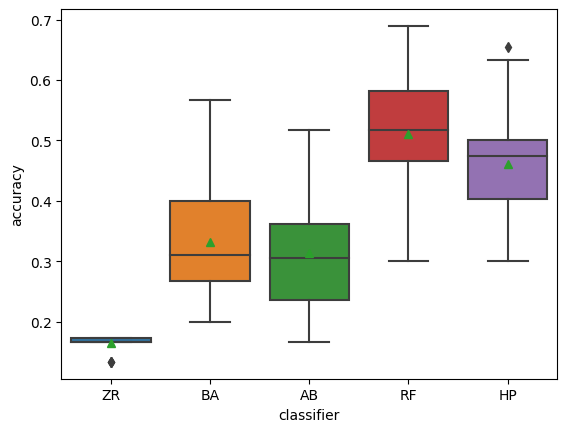

In [98]:
zR_scores_df = pd.DataFrame(scores_zR, columns=['accuracy']).assign(classifier='ZR')
ba_scores_df = pd.DataFrame(scores_BA, columns=['accuracy']).assign(classifier='BA')
ab_scores_df = pd.DataFrame(scores_AB, columns=['accuracy']).assign(classifier='AB')
rf_scores_df = pd.DataFrame(scores_RF, columns=['accuracy']).assign(classifier='RF')
hp_scores_df = pd.DataFrame(scores_HP, columns=['accuracy']).assign(classifier='HP')

boxplot = sns.boxplot(
    x='classifier',
    y='accuracy', 
    data=pd.concat([zR_scores_df, ba_scores_df, ab_scores_df, rf_scores_df, hp_scores_df]),
    showmeans=True
)

# Teste T pareado e Wilcoxon

In [100]:
print('t pareado')

stat, p = stats.ttest_rel(scores_zR, scores_BA)
print (f'ZR <> BA: {p:.3f}')

stat, p = stats.ttest_rel(scores_zR, scores_AB)
print (f'ZR <> AB: {p:.3f}')

stat, p = stats.ttest_rel(scores_zR, scores_RF)
print (f'ZR <> RF: {p:.3f}')

stat, p = stats.ttest_rel(scores_zR, scores_HP)
print (f'ZR <> HP: {p:.3f}')

stat, p = stats.ttest_rel(scores_BA, scores_AB)
print (f'BA <> AB: {p:.3f}')

stat, p = stats.ttest_rel(scores_BA, scores_RF)
print (f'BA <> RF: {p:.3f}')

stat, p = stats.ttest_rel(scores_BA, scores_HP)
print (f'BA <> HP: {p:.3f}')

stat, p = stats.ttest_rel(scores_AB, scores_RF)
print (f'AB <> RF: {p:.3f}')

stat, p = stats.ttest_rel(scores_AB, scores_HP)
print (f'AB <> HP: {p:.3f}')

stat, p = stats.ttest_rel(scores_RF, scores_HP)
print (f'RF <> HP: {p:.3f}')


print('wilcoxon')

stat, p = stats.wilcoxon(scores_zR, scores_BA)
print (f'ZR <> BA: {p:.3f}')

stat, p = stats.wilcoxon(scores_zR, scores_AB)
print (f'ZR <> AB: {p:.3f}')

stat, p = stats.wilcoxon(scores_zR, scores_RF)
print (f'ZR <> RF: {p:.3f}')

stat, p = stats.wilcoxon(scores_zR, scores_HP)
print (f'ZR <> HP: {p:.3f}')

stat, p = stats.wilcoxon(scores_BA, scores_AB)
print (f'BA <> AB: {p:.3f}')

stat, p = stats.wilcoxon(scores_BA, scores_RF)
print (f'BA <> RF: {p:.3f}')

stat, p = stats.wilcoxon(scores_BA, scores_HP)
print (f'BA <> HP: {p:.3f}')

stat, p = stats.wilcoxon(scores_AB, scores_RF)
print (f'AB <> RF: {p:.3f}')

stat, p = stats.wilcoxon(scores_AB, scores_HP)
print (f'AB <> HP: {p:.3f}')

stat, p = stats.wilcoxon(scores_RF, scores_HP)
print (f'RF <> HP: {p:.3f}')



t pareado
ZR <> BA: 0.000
ZR <> AB: 0.000
ZR <> RF: 0.000
ZR <> HP: 0.000
BA <> AB: 0.430
BA <> RF: 0.000
BA <> HP: 0.000
AB <> RF: 0.000
AB <> HP: 0.000
RF <> HP: 0.004
wilcoxon
ZR <> BA: 0.000
ZR <> AB: 0.000
ZR <> RF: 0.000
ZR <> HP: 0.000
BA <> AB: 0.484
BA <> RF: 0.000
BA <> HP: 0.000
AB <> RF: 0.000
AB <> HP: 0.000
RF <> HP: 0.003
